# IMDB Movie Review Sentiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import glob, os, re
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, GRU, Masking, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Reading in Train and Test Data

In this section I load in the training and testing datasets and store them in pandas dataframes. I also read in the IDs of the movie sentiments as well as their ratings. This information is not required for this task, but I've loaded it in for the sake of completeness.

In [2]:
# Extracting and storing the IDs and Ratings
os.chdir(r'C:\Users\Lukas\Desktop\Imdb\train\pos')
pos_train_names = glob.glob('*.txt')
os.chdir(r'C:\Users\Lukas\Desktop\Imdb\train\neg')
neg_train_names = glob.glob('*.txt')
os.chdir(r'C:\Users\Lukas\Desktop\Imdb\test\pos')
pos_test_names = glob.glob('*.txt')
os.chdir(r'C:\Users\Lukas\Desktop\Imdb\test\neg')
neg_test_names = glob.glob('*.txt')

def extract_id_and_rating(file_names):    
    ids = [name.split("_")[0] for name in file_names]
    ratings = [name.split("_")[1].split(".")[0] for name in file_names]
    return (ids, ratings)  

pos_train_ids, pos_train_ratings = extract_id_and_rating(pos_train_names)
neg_train_ids, neg_train_ratings = extract_id_and_rating(neg_train_names)
pos_test_ids, pos_test_ratings = extract_id_and_rating(pos_test_names)
neg_test_ids, neg_test_ratings = extract_id_and_rating(neg_test_names)

# Extracting the reviews and storing them
pos_train_names = glob.glob(r'C:\Users\Lukas\Desktop\Imdb\train\pos\*.txt')
neg_train_names = glob.glob(r'C:\Users\Lukas\Desktop\Imdb\train\neg\*.txt')
pos_test_names = glob.glob(r'C:\Users\Lukas\Desktop\Imdb\test\pos\*.txt')
neg_test_names = glob.glob(r'C:\Users\Lukas\Desktop\Imdb\test\neg\*.txt')


# Creating the training dataframe
train_df = pd.DataFrame({"data":[], "rating":[], "is_positive":[]})

# Adding positive sentiment training data
for idx, file_path in enumerate(pos_train_names):
    with open(file_path, encoding="utf-8") as file:
        train_df = train_df.append(pd.DataFrame({"data":file.read(), "rating":pos_train_ratings[idx],
                                            "is_positive":1}, index=[pos_train_ids[idx]]))
    
# Adding negative sentiment training data
for idx, file_path in enumerate(neg_train_names):
    with open(file_path, encoding="utf-8") as file:
        train_df = train_df.append(pd.DataFrame({"data":file.read(), "rating":neg_train_ratings[idx],
                                            "is_positive":0}, index=[neg_train_ids[idx]]))


# Creating the testing dataframe
test_df = pd.DataFrame({"data":[], "rating":[], "is_positive":[]})

# Adding positive sentiment testing data
for idx, file_path in enumerate(pos_test_names):
    with open(file_path, encoding="utf-8") as file:
        test_df = test_df.append(pd.DataFrame({"data":file.read(), "rating":pos_test_ratings[idx],
                                            "is_positive":1}, index=[pos_test_ids[idx]]))
    
# Adding negative sentiment testing data
for idx, file_path in enumerate(neg_test_names):
    with open(file_path, encoding="utf-8") as file:
        test_df = test_df.append(pd.DataFrame({"data":file.read(), "rating":neg_test_ratings[idx],
                                            "is_positive":0}, index=[neg_test_ids[idx]]))

In [3]:
# Setting correct data types, fixing some other details
train_df[["rating", "is_positive"]] =  train_df[["rating", "is_positive"]].astype("int")
train_df.index = train_df.index.astype("int")
train_df = train_df.reset_index(drop=True)


test_df[["rating", "is_positive"]] =  test_df[["rating", "is_positive"]].astype("int")
test_df.index = test_df.index.astype("int")
test_df = test_df.reset_index(drop=True)

## Word Vectorization and Preprocessing

### Defining Custom Functions

In [4]:
def get_word_vector_dict(url_or_path):
    """ Input: url_or_path, a URL or a local path to word embeddings.
        Output: word_vector_dict, a dictionary of GloVe word vectors where words are the keys
        and the values are the word vectors with the dimension specified in the input file."""
    with open(url_or_path, encoding="utf8") as glove_text:
        word_embeddings = [line.split(" ") for line in glove_text.readlines()]
    word_vector_dict = {element[0]:list(map(float, element[1:])) for element in word_embeddings}
    
    return word_vector_dict


def preprocess_text(string):
    """ Removes punctuation from a string and transforms the text to lower case.
        Input: textual data, string datatype.
        Output: preprocessed piece of text, string datatype. """
    # Replacing weird apostrophes
    string = re.sub("``", '"', string)
    string = re.sub("''", '"', string)
    # Getting rid of punctuation
    string = re.sub("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])", "", string.lower())
    string = re.sub("(<br\s*/><br\s*/>)|(\-)|(\/)", "  ", string)
    
    return string


def tokenize(string):
    """ Takes a string and returns the string as a list of tokens.
    Input: string, a str object.
    Output: a list of tokens, where each token is a substring. """
    tokens = word_tokenize(string)
    split_tokens = []
    
    for token in tokens:
        split_tokens.extend(re.split('(\W+)', token)) 
    
    return [token for token in split_tokens if token!=" " and token!=""]


def get_embedding(tokens):
    """ Takes a tokenized string and returns its vectorized/embedded form.
    Input: tokens, list of tokens of a string.
    Output: embedding, a numpy array of the vectorized/embedded representation of the string. """
    embedding=[]
    
    for token in np.array(tokens):
        if token in word_vector_50_dict.keys(): 
            embedding.extend(word_vector_50_dict[token])
        else:
            # Words with no embedding are assigned the 'unk' token vectorization (already in GloVe)
            embedding.extend(word_vector_50_dict["unk"])
    
    return np.array(embedding)

I'm aware that Bag of Words were available for this task, however I decided to with GloVe word vectorizations instead (https://nlp.stanford.edu/projects/glove/). The reason for this is that the pre-trained word vectorizations that GloVe provides encode alot more information than a simple Bag of Words that is very much so a 'frequentist approach'. Though I haven't tested both 'sets of features' I'm positive that this is a much better approach (though the advantages might not be evident in binary sentiment analysis given the comparitive simplicity of the exercise). I chose 50-d word vectorizations to reduce the number of trainable parameters as much as possible.

For text preprocessing I decided to basically get rid of all punctuation and any strange symbols. The main reason for doing this was to reduce the maximum token size for the longest movie review. By doing this we reduced the maximum timestep count, amount of padding/masking needed. While this does not simplify the network topology, it does in theory reduce training times. Furthermore, the punctuation doesn't carry as much meaning in sentiment analysis tasks so removing it is at no detriment to the aim of the task (this wouldn't fly with Question Answering of course). Tokenization was performed using NLTKs *word_tokenize()* function, word vectorizations were taken care of by GloVe and padding was taken care of using keras' *pad_sequences()* function.

In [5]:
# Setting up the 50-dimentional GloVe word vectorizations
word_vector_50_dict = get_word_vector_dict("C:/Users/Lukas/Desktop/glove.6B.50d.txt")

# Preprocessing the reviews
preprocessed_reviews = np.array([preprocess_text(review) for review in train_df.data.values])

# Tokenizing the reviews
tokenized_reviews = np.array([tokenize(review) for review in preprocessed_reviews])
max_review_len = np.max([len(review) for review in tokenized_reviews])

# Embedding the reviews
embedded_inputs = [get_embedding(tokenized_review) for tokenized_review in tokenized_reviews]

## Building the Neural Network

I went with the GRU for a few reasons. Firstly, given that the task is inherently of sequencial nature, an RNN architecture is a no-brainer over a feed-forward neural net. GRU doesn't suffer as badly from the vanishing gradient problem (and we could suffer that here with some examples being 2000+ tokens long) like a vanilla RNN, however it is simpler than an LSTM meaning fewer parameters and in theory shorter training times. Of course we could have gone for something more advanced like a Dynamic Memory Network, however I feel like that would be overkill for this sort of task (especially when logistic regression does a pretty good job as it is). Hyperparameters were chosen almost arbitrarily, however due to time constraints they were not optimized (early stopping was added in case training ceased ealier than expected). Given that the labels were '1' for positive sentiment and '0' for negative sentiment, binary cross-entropy was chosen as the loss function. A single unit dense 'layer' was added to output a prediction (sigmoid to ensure that the output space was [0,1], as required by the problem formulation).
### Defining and Setting Hyperparameters


In [6]:
num_of_samples = len(train_df.data.values)
num_of_epochs = 20
batch_size = 100
num_of_batches = int(num_of_samples/batch_size) # Number of iterations
learning_rate = 0.001
dropout = 0.25
l2_hyperparameter = 0.01

### Defining Network Topology

In [7]:
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(max_review_len, 50), name="Input/Masking"))
model.add(GRU(30, kernel_regularizer=l2(l2_hyperparameter), name="GRU"))
model.add(Dropout(dropout, name="Dropout"))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_hyperparameter), name="Output"))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input/Masking (Masking)      (None, 2474, 50)          0         
_________________________________________________________________
GRU (GRU)                    (None, 30)                7290      
_________________________________________________________________
Dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 31        
Total params: 7,321
Trainable params: 7,321
Non-trainable params: 0
_________________________________________________________________
None


Up to this point, the dataset has not been shuffled and all the positive reviews were followed by all the negative reviews. This is not ideal, so we shuffled the dataset while keeping the distribution of positive and negative samples roughly even (using stratify keyword argument of *train_test_split*). I couldn't store all of the padded inputs in memory, so I decided to run training within a for loop to alleviate the memory problems by storing the padded_inputs as local variables (overwriting the variable during each iteration) which obviously only exist in the scope of the for loop. Reshaping of the padded_sequences is required as the GRU expects a 3D tensor of shape (number_of_samples, timesteps, embedding size). Validation split was also provided so we could get a rough idea of generalizability performance during training. History objects were saved so we could visualise this data post training. I wanted to do it for each batch, however I quickly ran out of RAM and the notebook crashed.

In [8]:
# Shuffling data to disperse more evenly the positive and negative samples.
X_train, X_val, y_train, y_val = train_test_split(embedded_inputs, train_df.is_positive, test_size=0.1,
                                                  random_state=42, stratify=train_df.is_positive)
# Putting it back together
X = np.append(X_train, X_val)
y = np.append(y_train, y_val)

# We have to train in batches since we can't store all of the embedded/padded reviews in memory.
history_objects = []
batch_iteration = 0

for epoch in range(num_of_epochs): 
    for batch_idx in range(num_of_batches):
        print("\nEpoch %d/%d   Batch %d/%d" % (epoch+1, num_of_epochs, batch_iteration+1, num_of_batches))
        start, end = (batch_idx*batch_size, (batch_idx+1)*batch_size)
    
        padded_inputs = pad_sequences(X[start:end], max_review_len*50, padding="post",
                              dtype="float32").reshape(batch_size, -1, 50)
        labels = y[start:end]
    
        history = model.fit(x=padded_inputs, y=labels, batch_size=batch_size,
                            validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
        
        batch_iteration+=1
    
    # I wanted to add data for all batches, however I ran out of memory.
    history_objects.append(history)
    batch_iteration = 0 # Reset batch iteration counter for each new epoch


Epoch 1/20   Batch 1/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 2s 19ms/step - loss: 1.3616 - acc: 0.5444 - val_loss: 1.3042 - val_acc: 0.7000

Epoch 1/20   Batch 2/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 1.3323 - acc: 0.5778 - val_loss: 1.3801 - val_acc: 0.4000

Epoch 1/20   Batch 3/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 1.3652 - acc: 0.5000 - val_loss: 1.3460 - val_acc: 0.5000

Epoch 1/20   Batch 4/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 1.3655 - acc: 0.4778 - val_loss: 1.2773 - val_acc: 0.6000

Epoch 1/20   Batch 5/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 1.2980 - acc: 0.5556 - val_loss: 1.3462 - val_acc: 0.5000



Epoch 1/20   Batch 42/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 1.0635 - acc: 0.5667 - val_loss: 1.0846 - val_acc: 0.5000

Epoch 1/20   Batch 43/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 1.0750 - acc: 0.5889 - val_loss: 1.0749 - val_acc: 0.6000

Epoch 1/20   Batch 44/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 1.0808 - acc: 0.5000 - val_loss: 1.0473 - val_acc: 0.8000

Epoch 1/20   Batch 45/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 1.0781 - acc: 0.5222 - val_loss: 1.0851 - val_acc: 0.6000

Epoch 1/20   Batch 46/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 1.0795 - acc: 0.5000 - val_loss: 1.1002 - val_acc: 0.


Epoch 1/20   Batch 83/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.9066 - acc: 0.6444 - val_loss: 0.9144 - val_acc: 0.5000

Epoch 1/20   Batch 84/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.9457 - acc: 0.5778 - val_loss: 0.9401 - val_acc: 0.6000

Epoch 1/20   Batch 85/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.9027 - acc: 0.5333 - val_loss: 0.9478 - val_acc: 0.6000

Epoch 1/20   Batch 86/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.9049 - acc: 0.5667 - val_loss: 0.8944 - val_acc: 0.5000

Epoch 1/20   Batch 87/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.9263 - acc: 0.5222 - val_loss: 0.7893 - val_acc: 0.


Epoch 1/20   Batch 124/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.8162 - acc: 0.5667 - val_loss: 0.7705 - val_acc: 0.7000

Epoch 1/20   Batch 125/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.8095 - acc: 0.5889 - val_loss: 0.7203 - val_acc: 0.8000

Epoch 1/20   Batch 126/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.8002 - acc: 0.6556 - val_loss: 0.7151 - val_acc: 0.9000

Epoch 1/20   Batch 127/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.7893 - acc: 0.7111 - val_loss: 0.7657 - val_acc: 0.7000

Epoch 1/20   Batch 128/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.8345 - acc: 0.5778 - val_loss: 0.8072 - val_ac


Epoch 1/20   Batch 165/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6914 - acc: 0.7333 - val_loss: 0.8204 - val_acc: 0.6000

Epoch 1/20   Batch 166/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.6307 - acc: 0.7444 - val_loss: 0.8172 - val_acc: 0.7000

Epoch 1/20   Batch 167/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6710 - acc: 0.6778 - val_loss: 0.6913 - val_acc: 0.6000

Epoch 1/20   Batch 168/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6740 - acc: 0.7222 - val_loss: 0.6767 - val_acc: 0.7000

Epoch 1/20   Batch 169/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5569 - acc: 0.7778 - val_loss: 1.1624 - val_ac


Epoch 1/20   Batch 206/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.6290 - acc: 0.7444 - val_loss: 0.9237 - val_acc: 0.5000

Epoch 1/20   Batch 207/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.6730 - acc: 0.7000 - val_loss: 0.4637 - val_acc: 0.9000

Epoch 1/20   Batch 208/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6226 - acc: 0.6889 - val_loss: 0.6387 - val_acc: 0.7000

Epoch 1/20   Batch 209/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6441 - acc: 0.7111 - val_loss: 0.5537 - val_acc: 0.8000

Epoch 1/20   Batch 210/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.7504 - acc: 0.6222 - val_loss: 0.9758 - val_ac


Epoch 1/20   Batch 247/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6391 - acc: 0.7444 - val_loss: 0.9206 - val_acc: 0.5000

Epoch 1/20   Batch 248/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6627 - acc: 0.6556 - val_loss: 0.5908 - val_acc: 0.7000

Epoch 1/20   Batch 249/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5612 - acc: 0.7778 - val_loss: 0.5550 - val_acc: 0.8000

Epoch 1/20   Batch 250/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6571 - acc: 0.7556 - val_loss: 0.7082 - val_acc: 0.6000

Epoch 2/20   Batch 1/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6343 - acc: 0.7000 - val_loss: 0.6225 - val_acc:


Epoch 2/20   Batch 38/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5868 - acc: 0.7667 - val_loss: 0.4010 - val_acc: 0.9000

Epoch 2/20   Batch 39/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6165 - acc: 0.7000 - val_loss: 0.7667 - val_acc: 0.6000

Epoch 2/20   Batch 40/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5321 - acc: 0.8111 - val_loss: 0.8896 - val_acc: 0.6000

Epoch 2/20   Batch 41/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5982 - acc: 0.7778 - val_loss: 0.3875 - val_acc: 0.9000

Epoch 2/20   Batch 42/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5420 - acc: 0.7667 - val_loss: 0.5353 - val_acc: 0.


Epoch 2/20   Batch 79/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6000 - acc: 0.7444 - val_loss: 0.4833 - val_acc: 0.8000

Epoch 2/20   Batch 80/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5692 - acc: 0.7778 - val_loss: 0.5485 - val_acc: 0.7000

Epoch 2/20   Batch 81/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.6021 - acc: 0.7222 - val_loss: 0.5213 - val_acc: 0.6000

Epoch 2/20   Batch 82/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5321 - acc: 0.7778 - val_loss: 0.6845 - val_acc: 0.8000

Epoch 2/20   Batch 83/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5002 - acc: 0.8444 - val_loss: 0.4601 - val_acc: 0.


Epoch 2/20   Batch 120/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5457 - acc: 0.7667 - val_loss: 0.4138 - val_acc: 0.8000

Epoch 2/20   Batch 121/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5293 - acc: 0.7778 - val_loss: 0.4794 - val_acc: 0.7000

Epoch 2/20   Batch 122/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5134 - acc: 0.8556 - val_loss: 0.3414 - val_acc: 1.0000

Epoch 2/20   Batch 123/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5351 - acc: 0.8222 - val_loss: 0.4708 - val_acc: 0.9000

Epoch 2/20   Batch 124/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5819 - acc: 0.7000 - val_loss: 0.2486 - val_ac


Epoch 2/20   Batch 161/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4846 - acc: 0.8444 - val_loss: 0.8359 - val_acc: 0.6000

Epoch 2/20   Batch 162/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5459 - acc: 0.7556 - val_loss: 0.6079 - val_acc: 0.6000

Epoch 2/20   Batch 163/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5469 - acc: 0.7889 - val_loss: 0.3838 - val_acc: 0.9000

Epoch 2/20   Batch 164/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5543 - acc: 0.7667 - val_loss: 0.4287 - val_acc: 1.0000

Epoch 2/20   Batch 165/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5704 - acc: 0.7778 - val_loss: 0.6332 - val_ac


Epoch 2/20   Batch 202/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5337 - acc: 0.7778 - val_loss: 0.4535 - val_acc: 0.9000

Epoch 2/20   Batch 203/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5484 - acc: 0.7333 - val_loss: 0.4030 - val_acc: 0.9000

Epoch 2/20   Batch 204/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5709 - acc: 0.7778 - val_loss: 0.4664 - val_acc: 0.8000

Epoch 2/20   Batch 205/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5049 - acc: 0.7778 - val_loss: 0.6745 - val_acc: 0.6000

Epoch 2/20   Batch 206/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4914 - acc: 0.8000 - val_loss: 0.8210 - val_ac


Epoch 2/20   Batch 243/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5046 - acc: 0.8000 - val_loss: 0.3234 - val_acc: 0.9000

Epoch 2/20   Batch 244/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5441 - acc: 0.7889 - val_loss: 0.7145 - val_acc: 0.7000

Epoch 2/20   Batch 245/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5890 - acc: 0.7778 - val_loss: 0.4866 - val_acc: 0.8000

Epoch 2/20   Batch 246/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5361 - acc: 0.7667 - val_loss: 0.4618 - val_acc: 0.8000

Epoch 2/20   Batch 247/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6412 - acc: 0.7111 - val_loss: 0.8679 - val_ac


Epoch 3/20   Batch 34/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4575 - acc: 0.8444 - val_loss: 0.4672 - val_acc: 0.9000

Epoch 3/20   Batch 35/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.6437 - acc: 0.7222 - val_loss: 1.1431 - val_acc: 0.4000

Epoch 3/20   Batch 36/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4618 - acc: 0.8333 - val_loss: 0.6568 - val_acc: 0.7000

Epoch 3/20   Batch 37/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5233 - acc: 0.8111 - val_loss: 0.4210 - val_acc: 0.9000

Epoch 3/20   Batch 38/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4964 - acc: 0.8000 - val_loss: 0.3121 - val_acc: 1.


Epoch 3/20   Batch 75/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4250 - acc: 0.8333 - val_loss: 0.3000 - val_acc: 0.9000

Epoch 3/20   Batch 76/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4343 - acc: 0.8444 - val_loss: 0.2823 - val_acc: 0.9000

Epoch 3/20   Batch 77/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3725 - acc: 0.8778 - val_loss: 0.4475 - val_acc: 0.9000

Epoch 3/20   Batch 78/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5598 - acc: 0.7333 - val_loss: 0.4635 - val_acc: 0.9000

Epoch 3/20   Batch 79/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5460 - acc: 0.7667 - val_loss: 0.4590 - val_acc: 0.


Epoch 3/20   Batch 116/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4716 - acc: 0.8222 - val_loss: 0.4417 - val_acc: 0.8000

Epoch 3/20   Batch 117/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4507 - acc: 0.8000 - val_loss: 0.2861 - val_acc: 1.0000

Epoch 3/20   Batch 118/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4820 - acc: 0.8000 - val_loss: 0.4383 - val_acc: 0.8000

Epoch 3/20   Batch 119/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5031 - acc: 0.7778 - val_loss: 0.7359 - val_acc: 0.7000

Epoch 3/20   Batch 120/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5001 - acc: 0.8000 - val_loss: 0.3056 - val_ac


Epoch 3/20   Batch 157/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4713 - acc: 0.8333 - val_loss: 0.3945 - val_acc: 0.9000

Epoch 3/20   Batch 158/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4802 - acc: 0.8111 - val_loss: 0.3710 - val_acc: 0.9000

Epoch 3/20   Batch 159/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5276 - acc: 0.7556 - val_loss: 0.4546 - val_acc: 0.8000

Epoch 3/20   Batch 160/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5332 - acc: 0.7444 - val_loss: 0.2941 - val_acc: 1.0000

Epoch 3/20   Batch 161/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4345 - acc: 0.8444 - val_loss: 0.7282 - val_ac


Epoch 3/20   Batch 198/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5016 - acc: 0.8000 - val_loss: 0.5714 - val_acc: 0.7000

Epoch 3/20   Batch 199/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4191 - acc: 0.8556 - val_loss: 0.5921 - val_acc: 0.7000

Epoch 3/20   Batch 200/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5816 - acc: 0.7333 - val_loss: 0.2758 - val_acc: 1.0000

Epoch 3/20   Batch 201/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5322 - acc: 0.8111 - val_loss: 0.4222 - val_acc: 0.9000

Epoch 3/20   Batch 202/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4845 - acc: 0.7556 - val_loss: 0.4770 - val_ac


Epoch 3/20   Batch 239/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4397 - acc: 0.8111 - val_loss: 0.5973 - val_acc: 0.8000

Epoch 3/20   Batch 240/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5496 - acc: 0.7222 - val_loss: 0.5129 - val_acc: 0.9000

Epoch 3/20   Batch 241/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4820 - acc: 0.8333 - val_loss: 0.4595 - val_acc: 0.7000

Epoch 3/20   Batch 242/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5145 - acc: 0.7667 - val_loss: 0.3480 - val_acc: 0.9000

Epoch 3/20   Batch 243/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4752 - acc: 0.7778 - val_loss: 0.2874 - val_ac


Epoch 4/20   Batch 30/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4029 - acc: 0.8222 - val_loss: 0.4601 - val_acc: 0.8000

Epoch 4/20   Batch 31/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4222 - acc: 0.8444 - val_loss: 0.5872 - val_acc: 0.8000

Epoch 4/20   Batch 32/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3818 - acc: 0.8778 - val_loss: 0.4880 - val_acc: 0.7000

Epoch 4/20   Batch 33/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4326 - acc: 0.8222 - val_loss: 0.7395 - val_acc: 0.7000

Epoch 4/20   Batch 34/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3670 - acc: 0.8778 - val_loss: 0.4964 - val_acc: 0.


Epoch 4/20   Batch 71/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4118 - acc: 0.8111 - val_loss: 0.6897 - val_acc: 0.7000

Epoch 4/20   Batch 72/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5155 - acc: 0.8222 - val_loss: 0.4573 - val_acc: 0.8000

Epoch 4/20   Batch 73/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6234 - acc: 0.7333 - val_loss: 0.7173 - val_acc: 0.7000

Epoch 4/20   Batch 74/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4832 - acc: 0.8333 - val_loss: 0.3750 - val_acc: 0.9000

Epoch 4/20   Batch 75/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3801 - acc: 0.9111 - val_loss: 0.2871 - val_acc: 0.


Epoch 4/20   Batch 112/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4817 - acc: 0.8778 - val_loss: 0.4565 - val_acc: 0.9000

Epoch 4/20   Batch 113/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4610 - acc: 0.8111 - val_loss: 0.6374 - val_acc: 0.7000

Epoch 4/20   Batch 114/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5780 - acc: 0.7667 - val_loss: 0.3805 - val_acc: 0.9000

Epoch 4/20   Batch 115/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5495 - acc: 0.7222 - val_loss: 0.2233 - val_acc: 1.0000

Epoch 4/20   Batch 116/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4723 - acc: 0.8333 - val_loss: 0.3614 - val_ac


Epoch 4/20   Batch 153/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4226 - acc: 0.8333 - val_loss: 0.4068 - val_acc: 0.9000

Epoch 4/20   Batch 154/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3905 - acc: 0.8556 - val_loss: 0.5959 - val_acc: 0.7000

Epoch 4/20   Batch 155/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4677 - acc: 0.7778 - val_loss: 0.3790 - val_acc: 0.9000

Epoch 4/20   Batch 156/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4757 - acc: 0.8333 - val_loss: 0.5412 - val_acc: 0.8000

Epoch 4/20   Batch 157/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4681 - acc: 0.8444 - val_loss: 0.4076 - val_ac


Epoch 4/20   Batch 194/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3994 - acc: 0.8667 - val_loss: 0.4565 - val_acc: 0.9000

Epoch 4/20   Batch 195/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3953 - acc: 0.8667 - val_loss: 0.3276 - val_acc: 0.9000

Epoch 4/20   Batch 196/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4239 - acc: 0.8444 - val_loss: 0.2917 - val_acc: 0.9000

Epoch 4/20   Batch 197/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3959 - acc: 0.8333 - val_loss: 0.6652 - val_acc: 0.7000

Epoch 4/20   Batch 198/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4827 - acc: 0.8222 - val_loss: 0.5070 - val_ac


Epoch 4/20   Batch 235/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5347 - acc: 0.7667 - val_loss: 0.4482 - val_acc: 0.7000

Epoch 4/20   Batch 236/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4237 - acc: 0.8222 - val_loss: 0.6428 - val_acc: 0.8000

Epoch 4/20   Batch 237/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3744 - acc: 0.8556 - val_loss: 0.4284 - val_acc: 0.8000

Epoch 4/20   Batch 238/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5669 - acc: 0.7667 - val_loss: 0.6401 - val_acc: 0.7000

Epoch 4/20   Batch 239/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4332 - acc: 0.8333 - val_loss: 0.6054 - val_ac


Epoch 5/20   Batch 26/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3795 - acc: 0.8889 - val_loss: 0.4054 - val_acc: 0.8000

Epoch 5/20   Batch 27/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4101 - acc: 0.8222 - val_loss: 0.2967 - val_acc: 0.9000

Epoch 5/20   Batch 28/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5067 - acc: 0.7778 - val_loss: 0.5546 - val_acc: 0.7000

Epoch 5/20   Batch 29/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4406 - acc: 0.8444 - val_loss: 0.4513 - val_acc: 0.8000

Epoch 5/20   Batch 30/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3600 - acc: 0.8333 - val_loss: 0.4179 - val_acc: 0.


Epoch 5/20   Batch 67/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4899 - acc: 0.7778 - val_loss: 0.4352 - val_acc: 0.9000

Epoch 5/20   Batch 68/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3347 - acc: 0.9000 - val_loss: 0.2571 - val_acc: 0.9000

Epoch 5/20   Batch 69/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3568 - acc: 0.8778 - val_loss: 0.5683 - val_acc: 0.8000

Epoch 5/20   Batch 70/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3308 - acc: 0.8667 - val_loss: 0.3945 - val_acc: 0.9000

Epoch 5/20   Batch 71/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3700 - acc: 0.8556 - val_loss: 0.6579 - val_acc: 0.


Epoch 5/20   Batch 108/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5286 - acc: 0.8111 - val_loss: 0.3667 - val_acc: 0.9000

Epoch 5/20   Batch 109/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3783 - acc: 0.8778 - val_loss: 0.3274 - val_acc: 0.9000

Epoch 5/20   Batch 110/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4699 - acc: 0.7556 - val_loss: 0.4783 - val_acc: 0.8000

Epoch 5/20   Batch 111/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4563 - acc: 0.7778 - val_loss: 0.8440 - val_acc: 0.6000

Epoch 5/20   Batch 112/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4391 - acc: 0.8889 - val_loss: 0.4301 - val_ac


Epoch 5/20   Batch 149/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4684 - acc: 0.8222 - val_loss: 0.3548 - val_acc: 0.9000

Epoch 5/20   Batch 150/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3815 - acc: 0.8556 - val_loss: 0.3956 - val_acc: 0.9000

Epoch 5/20   Batch 151/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4487 - acc: 0.8778 - val_loss: 0.3411 - val_acc: 0.9000

Epoch 5/20   Batch 152/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4303 - acc: 0.8444 - val_loss: 0.3470 - val_acc: 0.9000

Epoch 5/20   Batch 153/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4283 - acc: 0.8000 - val_loss: 0.3972 - val_ac


Epoch 5/20   Batch 190/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4322 - acc: 0.8444 - val_loss: 0.1863 - val_acc: 1.0000

Epoch 5/20   Batch 191/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4137 - acc: 0.8333 - val_loss: 0.3821 - val_acc: 0.9000

Epoch 5/20   Batch 192/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3595 - acc: 0.8889 - val_loss: 0.4355 - val_acc: 0.9000

Epoch 5/20   Batch 193/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5519 - acc: 0.7778 - val_loss: 0.2981 - val_acc: 0.9000

Epoch 5/20   Batch 194/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3863 - acc: 0.8889 - val_loss: 0.4622 - val_ac


Epoch 5/20   Batch 231/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3774 - acc: 0.8778 - val_loss: 0.7865 - val_acc: 0.7000

Epoch 5/20   Batch 232/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4376 - acc: 0.8222 - val_loss: 0.3368 - val_acc: 0.8000

Epoch 5/20   Batch 233/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4560 - acc: 0.8222 - val_loss: 0.3431 - val_acc: 0.9000

Epoch 5/20   Batch 234/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3879 - acc: 0.8667 - val_loss: 0.3944 - val_acc: 0.9000

Epoch 5/20   Batch 235/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5022 - acc: 0.7778 - val_loss: 0.4185 - val_ac


Epoch 6/20   Batch 22/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4191 - acc: 0.8222 - val_loss: 0.9258 - val_acc: 0.6000

Epoch 6/20   Batch 23/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4120 - acc: 0.8222 - val_loss: 0.6728 - val_acc: 0.7000

Epoch 6/20   Batch 24/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3975 - acc: 0.8222 - val_loss: 0.3772 - val_acc: 0.9000

Epoch 6/20   Batch 25/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4673 - acc: 0.8000 - val_loss: 0.8219 - val_acc: 0.6000

Epoch 6/20   Batch 26/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3882 - acc: 0.8778 - val_loss: 0.4152 - val_acc: 0.


Epoch 6/20   Batch 63/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3861 - acc: 0.8556 - val_loss: 0.1203 - val_acc: 1.0000

Epoch 6/20   Batch 64/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3919 - acc: 0.8333 - val_loss: 0.6069 - val_acc: 0.8000

Epoch 6/20   Batch 65/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4513 - acc: 0.8667 - val_loss: 0.5994 - val_acc: 0.7000

Epoch 6/20   Batch 66/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4685 - acc: 0.8222 - val_loss: 0.2687 - val_acc: 0.9000

Epoch 6/20   Batch 67/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4778 - acc: 0.7778 - val_loss: 0.4436 - val_acc: 0.


Epoch 6/20   Batch 104/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4241 - acc: 0.8333 - val_loss: 0.2712 - val_acc: 0.9000

Epoch 6/20   Batch 105/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4513 - acc: 0.8444 - val_loss: 0.5759 - val_acc: 0.7000

Epoch 6/20   Batch 106/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4617 - acc: 0.8333 - val_loss: 0.3016 - val_acc: 0.9000

Epoch 6/20   Batch 107/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5329 - acc: 0.7667 - val_loss: 0.6011 - val_acc: 0.7000

Epoch 6/20   Batch 108/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5126 - acc: 0.8000 - val_loss: 0.3328 - val_ac


Epoch 6/20   Batch 145/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4444 - acc: 0.8333 - val_loss: 0.2202 - val_acc: 1.0000

Epoch 6/20   Batch 146/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.6126 - acc: 0.8000 - val_loss: 0.3849 - val_acc: 0.9000

Epoch 6/20   Batch 147/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4520 - acc: 0.8222 - val_loss: 0.5073 - val_acc: 0.7000

Epoch 6/20   Batch 148/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4510 - acc: 0.8333 - val_loss: 0.5771 - val_acc: 0.7000

Epoch 6/20   Batch 149/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4477 - acc: 0.8333 - val_loss: 0.3037 - val_ac


Epoch 6/20   Batch 186/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4430 - acc: 0.8667 - val_loss: 0.5671 - val_acc: 0.7000

Epoch 6/20   Batch 187/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4029 - acc: 0.8222 - val_loss: 0.5571 - val_acc: 0.8000

Epoch 6/20   Batch 188/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4277 - acc: 0.8444 - val_loss: 0.4317 - val_acc: 0.9000

Epoch 6/20   Batch 189/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4715 - acc: 0.7889 - val_loss: 0.3364 - val_acc: 1.0000

Epoch 6/20   Batch 190/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4271 - acc: 0.8556 - val_loss: 0.1814 - val_ac


Epoch 6/20   Batch 227/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3706 - acc: 0.8667 - val_loss: 0.1947 - val_acc: 1.0000

Epoch 6/20   Batch 228/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5218 - acc: 0.8111 - val_loss: 0.2762 - val_acc: 0.9000

Epoch 6/20   Batch 229/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3657 - acc: 0.9000 - val_loss: 0.5431 - val_acc: 0.8000

Epoch 6/20   Batch 230/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3920 - acc: 0.8667 - val_loss: 0.7549 - val_acc: 0.6000

Epoch 6/20   Batch 231/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3580 - acc: 0.8556 - val_loss: 0.7335 - val_ac


Epoch 7/20   Batch 18/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4505 - acc: 0.8000 - val_loss: 0.3870 - val_acc: 0.7000

Epoch 7/20   Batch 19/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3937 - acc: 0.8667 - val_loss: 0.3034 - val_acc: 0.9000

Epoch 7/20   Batch 20/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3625 - acc: 0.8667 - val_loss: 0.4018 - val_acc: 0.8000

Epoch 7/20   Batch 21/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3318 - acc: 0.8889 - val_loss: 0.6096 - val_acc: 0.8000

Epoch 7/20   Batch 22/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4013 - acc: 0.8333 - val_loss: 0.9196 - val_acc: 0.


Epoch 7/20   Batch 59/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4010 - acc: 0.8333 - val_loss: 0.1873 - val_acc: 1.0000

Epoch 7/20   Batch 60/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3922 - acc: 0.8778 - val_loss: 0.4378 - val_acc: 0.7000

Epoch 7/20   Batch 61/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3368 - acc: 0.8667 - val_loss: 0.5337 - val_acc: 0.8000

Epoch 7/20   Batch 62/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4238 - acc: 0.8667 - val_loss: 0.6020 - val_acc: 0.7000

Epoch 7/20   Batch 63/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3686 - acc: 0.8556 - val_loss: 0.1010 - val_acc: 1.


Epoch 7/20   Batch 100/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4749 - acc: 0.8333 - val_loss: 0.4288 - val_acc: 0.8000

Epoch 7/20   Batch 101/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3400 - acc: 0.8556 - val_loss: 0.5190 - val_acc: 0.9000

Epoch 7/20   Batch 102/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4314 - acc: 0.8111 - val_loss: 0.2963 - val_acc: 0.9000

Epoch 7/20   Batch 103/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4854 - acc: 0.7889 - val_loss: 0.4619 - val_acc: 0.8000

Epoch 7/20   Batch 104/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4289 - acc: 0.8222 - val_loss: 0.2647 - val_ac


Epoch 7/20   Batch 141/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3636 - acc: 0.8667 - val_loss: 0.2817 - val_acc: 1.0000

Epoch 7/20   Batch 142/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3397 - acc: 0.8667 - val_loss: 0.4378 - val_acc: 0.8000

Epoch 7/20   Batch 143/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5827 - acc: 0.7444 - val_loss: 0.4381 - val_acc: 0.7000

Epoch 7/20   Batch 144/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4170 - acc: 0.8556 - val_loss: 0.3793 - val_acc: 0.8000

Epoch 7/20   Batch 145/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4348 - acc: 0.8222 - val_loss: 0.2345 - val_ac


Epoch 7/20   Batch 182/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3498 - acc: 0.8778 - val_loss: 0.4022 - val_acc: 0.9000

Epoch 7/20   Batch 183/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4426 - acc: 0.8556 - val_loss: 0.5005 - val_acc: 0.8000

Epoch 7/20   Batch 184/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3689 - acc: 0.8333 - val_loss: 0.3411 - val_acc: 0.9000

Epoch 7/20   Batch 185/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4226 - acc: 0.8444 - val_loss: 0.3549 - val_acc: 0.9000

Epoch 7/20   Batch 186/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4159 - acc: 0.8444 - val_loss: 0.5419 - val_ac


Epoch 7/20   Batch 223/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3953 - acc: 0.8333 - val_loss: 0.1592 - val_acc: 1.0000

Epoch 7/20   Batch 224/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3913 - acc: 0.8444 - val_loss: 0.3761 - val_acc: 0.9000

Epoch 7/20   Batch 225/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3988 - acc: 0.8222 - val_loss: 0.3579 - val_acc: 0.9000

Epoch 7/20   Batch 226/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4781 - acc: 0.8111 - val_loss: 0.5121 - val_acc: 0.8000

Epoch 7/20   Batch 227/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3881 - acc: 0.8667 - val_loss: 0.2053 - val_ac


Epoch 8/20   Batch 14/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4047 - acc: 0.8222 - val_loss: 0.5197 - val_acc: 0.8000

Epoch 8/20   Batch 15/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4685 - acc: 0.8222 - val_loss: 0.2907 - val_acc: 0.9000

Epoch 8/20   Batch 16/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4431 - acc: 0.8111 - val_loss: 0.5845 - val_acc: 0.8000

Epoch 8/20   Batch 17/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3747 - acc: 0.8222 - val_loss: 0.6835 - val_acc: 0.6000

Epoch 8/20   Batch 18/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4339 - acc: 0.8000 - val_loss: 0.4447 - val_acc: 0.


Epoch 8/20   Batch 55/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5075 - acc: 0.7667 - val_loss: 0.4530 - val_acc: 0.8000

Epoch 8/20   Batch 56/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3451 - acc: 0.8889 - val_loss: 0.6225 - val_acc: 0.6000

Epoch 8/20   Batch 57/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3917 - acc: 0.8889 - val_loss: 0.4149 - val_acc: 0.8000

Epoch 8/20   Batch 58/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3278 - acc: 0.9111 - val_loss: 0.1917 - val_acc: 1.0000

Epoch 8/20   Batch 59/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3933 - acc: 0.8556 - val_loss: 0.1930 - val_acc: 1.


Epoch 8/20   Batch 96/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4272 - acc: 0.8333 - val_loss: 0.2917 - val_acc: 0.8000

Epoch 8/20   Batch 97/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5009 - acc: 0.7889 - val_loss: 0.3504 - val_acc: 0.9000

Epoch 8/20   Batch 98/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4308 - acc: 0.8111 - val_loss: 0.3793 - val_acc: 0.9000

Epoch 8/20   Batch 99/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4260 - acc: 0.8111 - val_loss: 0.2539 - val_acc: 1.0000

Epoch 8/20   Batch 100/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4734 - acc: 0.8222 - val_loss: 0.4097 - val_acc: 0


Epoch 8/20   Batch 137/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5141 - acc: 0.8000 - val_loss: 0.4264 - val_acc: 0.8000

Epoch 8/20   Batch 138/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3824 - acc: 0.8667 - val_loss: 0.2895 - val_acc: 0.9000

Epoch 8/20   Batch 139/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4000 - acc: 0.8556 - val_loss: 0.4250 - val_acc: 0.8000

Epoch 8/20   Batch 140/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4528 - acc: 0.8333 - val_loss: 0.4850 - val_acc: 0.8000

Epoch 8/20   Batch 141/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3515 - acc: 0.8778 - val_loss: 0.2679 - val_ac


Epoch 8/20   Batch 178/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3932 - acc: 0.8333 - val_loss: 0.3499 - val_acc: 0.9000

Epoch 8/20   Batch 179/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3497 - acc: 0.8778 - val_loss: 0.2774 - val_acc: 0.9000

Epoch 8/20   Batch 180/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3424 - acc: 0.8778 - val_loss: 0.4192 - val_acc: 0.9000

Epoch 8/20   Batch 181/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4007 - acc: 0.8889 - val_loss: 0.3562 - val_acc: 0.9000

Epoch 8/20   Batch 182/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3338 - acc: 0.8667 - val_loss: 0.3905 - val_ac


Epoch 8/20   Batch 219/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4797 - acc: 0.8000 - val_loss: 0.5544 - val_acc: 0.7000

Epoch 8/20   Batch 220/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4227 - acc: 0.8222 - val_loss: 0.6740 - val_acc: 0.7000

Epoch 8/20   Batch 221/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3754 - acc: 0.9222 - val_loss: 0.4524 - val_acc: 0.8000

Epoch 8/20   Batch 222/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3521 - acc: 0.8667 - val_loss: 0.3188 - val_acc: 0.9000

Epoch 8/20   Batch 223/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4314 - acc: 0.8111 - val_loss: 0.1582 - val_ac


Epoch 9/20   Batch 10/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4206 - acc: 0.8333 - val_loss: 0.2315 - val_acc: 0.9000

Epoch 9/20   Batch 11/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4574 - acc: 0.8556 - val_loss: 0.3994 - val_acc: 0.9000

Epoch 9/20   Batch 12/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4021 - acc: 0.8333 - val_loss: 0.4202 - val_acc: 0.7000

Epoch 9/20   Batch 13/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3141 - acc: 0.9111 - val_loss: 0.3698 - val_acc: 0.9000

Epoch 9/20   Batch 14/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4144 - acc: 0.8333 - val_loss: 0.4875 - val_acc: 0.


Epoch 9/20   Batch 51/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5234 - acc: 0.8333 - val_loss: 0.4737 - val_acc: 0.8000

Epoch 9/20   Batch 52/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3659 - acc: 0.8444 - val_loss: 0.6005 - val_acc: 0.7000

Epoch 9/20   Batch 53/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3239 - acc: 0.9000 - val_loss: 0.1844 - val_acc: 1.0000

Epoch 9/20   Batch 54/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3701 - acc: 0.8667 - val_loss: 0.5180 - val_acc: 0.8000

Epoch 9/20   Batch 55/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5067 - acc: 0.7667 - val_loss: 0.4557 - val_acc: 0.


Epoch 9/20   Batch 92/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5395 - acc: 0.7889 - val_loss: 0.5835 - val_acc: 0.8000

Epoch 9/20   Batch 93/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4410 - acc: 0.8444 - val_loss: 0.4856 - val_acc: 0.9000

Epoch 9/20   Batch 94/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3515 - acc: 0.8778 - val_loss: 0.4541 - val_acc: 0.8000

Epoch 9/20   Batch 95/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4113 - acc: 0.8222 - val_loss: 0.7242 - val_acc: 0.7000

Epoch 9/20   Batch 96/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4437 - acc: 0.8111 - val_loss: 0.3244 - val_acc: 0.


Epoch 9/20   Batch 133/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3522 - acc: 0.8778 - val_loss: 0.3370 - val_acc: 0.9000

Epoch 9/20   Batch 134/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3773 - acc: 0.8556 - val_loss: 0.2762 - val_acc: 0.9000

Epoch 9/20   Batch 135/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3006 - acc: 0.9111 - val_loss: 0.2977 - val_acc: 0.9000

Epoch 9/20   Batch 136/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4057 - acc: 0.8444 - val_loss: 0.3899 - val_acc: 0.8000

Epoch 9/20   Batch 137/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4945 - acc: 0.7889 - val_loss: 0.4731 - val_ac


Epoch 9/20   Batch 174/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4869 - acc: 0.7889 - val_loss: 0.4480 - val_acc: 0.7000

Epoch 9/20   Batch 175/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3289 - acc: 0.8889 - val_loss: 0.6716 - val_acc: 0.7000

Epoch 9/20   Batch 176/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5700 - acc: 0.7889 - val_loss: 0.3732 - val_acc: 0.9000

Epoch 9/20   Batch 177/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3820 - acc: 0.8778 - val_loss: 0.3089 - val_acc: 0.8000

Epoch 9/20   Batch 178/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3898 - acc: 0.8556 - val_loss: 0.3425 - val_ac


Epoch 9/20   Batch 215/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4191 - acc: 0.8222 - val_loss: 0.2152 - val_acc: 0.9000

Epoch 9/20   Batch 216/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4152 - acc: 0.8444 - val_loss: 0.4980 - val_acc: 0.9000

Epoch 9/20   Batch 217/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4158 - acc: 0.7778 - val_loss: 0.0980 - val_acc: 1.0000

Epoch 9/20   Batch 218/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3939 - acc: 0.8444 - val_loss: 0.4688 - val_acc: 0.8000

Epoch 9/20   Batch 219/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4580 - acc: 0.8222 - val_loss: 0.5529 - val_ac


Epoch 10/20   Batch 6/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4563 - acc: 0.8000 - val_loss: 0.2978 - val_acc: 0.9000

Epoch 10/20   Batch 7/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3716 - acc: 0.8556 - val_loss: 0.2740 - val_acc: 0.9000

Epoch 10/20   Batch 8/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4899 - acc: 0.8000 - val_loss: 0.3372 - val_acc: 0.9000

Epoch 10/20   Batch 9/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3969 - acc: 0.8556 - val_loss: 0.1502 - val_acc: 1.0000

Epoch 10/20   Batch 10/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4297 - acc: 0.8333 - val_loss: 0.2347 - val_acc: 0


Epoch 10/20   Batch 47/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4627 - acc: 0.8111 - val_loss: 0.5238 - val_acc: 0.7000

Epoch 10/20   Batch 48/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4205 - acc: 0.8556 - val_loss: 0.4005 - val_acc: 0.8000

Epoch 10/20   Batch 49/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3394 - acc: 0.9000 - val_loss: 0.8175 - val_acc: 0.7000

Epoch 10/20   Batch 50/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4077 - acc: 0.8444 - val_loss: 0.4123 - val_acc: 0.8000

Epoch 10/20   Batch 51/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5143 - acc: 0.8444 - val_loss: 0.4497 - val_ac


Epoch 10/20   Batch 88/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3366 - acc: 0.9111 - val_loss: 0.3612 - val_acc: 0.9000

Epoch 10/20   Batch 89/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3888 - acc: 0.8333 - val_loss: 0.3104 - val_acc: 0.9000

Epoch 10/20   Batch 90/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3128 - acc: 0.9111 - val_loss: 0.4000 - val_acc: 0.8000

Epoch 10/20   Batch 91/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3839 - acc: 0.8444 - val_loss: 0.3049 - val_acc: 0.9000

Epoch 10/20   Batch 92/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4869 - acc: 0.8000 - val_loss: 0.5682 - val_ac


Epoch 10/20   Batch 129/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4696 - acc: 0.7556 - val_loss: 0.3079 - val_acc: 0.9000

Epoch 10/20   Batch 130/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4037 - acc: 0.8444 - val_loss: 0.3557 - val_acc: 0.8000

Epoch 10/20   Batch 131/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4113 - acc: 0.8111 - val_loss: 0.2105 - val_acc: 0.9000

Epoch 10/20   Batch 132/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3943 - acc: 0.8667 - val_loss: 0.4449 - val_acc: 0.8000

Epoch 10/20   Batch 133/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3511 - acc: 0.8889 - val_loss: 0.3378 - v

90/90 [==============================] - 1s 12ms/step - loss: 0.2728 - acc: 0.9111 - val_loss: 0.5285 - val_acc: 0.8000

Epoch 10/20   Batch 170/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3025 - acc: 0.9222 - val_loss: 0.6511 - val_acc: 0.6000

Epoch 10/20   Batch 171/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4055 - acc: 0.8333 - val_loss: 0.5564 - val_acc: 0.8000

Epoch 10/20   Batch 172/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4522 - acc: 0.8000 - val_loss: 0.7344 - val_acc: 0.6000

Epoch 10/20   Batch 173/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3109 - acc: 0.9111 - val_loss: 0.5290 - val_acc: 0.6000

Epoch 10/20   Batch 174/250
Train on 90 samples, validate on 10 sam


Epoch 10/20   Batch 210/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4935 - acc: 0.7889 - val_loss: 0.4938 - val_acc: 0.9000

Epoch 10/20   Batch 211/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4967 - acc: 0.8000 - val_loss: 0.2329 - val_acc: 1.0000

Epoch 10/20   Batch 212/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4139 - acc: 0.8667 - val_loss: 0.2424 - val_acc: 0.9000

Epoch 10/20   Batch 213/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4683 - acc: 0.7778 - val_loss: 0.2999 - val_acc: 0.9000

Epoch 10/20   Batch 214/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3820 - acc: 0.8556 - val_loss: 0.3345 - v

90/90 [==============================] - 1s 11ms/step - loss: 0.4847 - acc: 0.8111 - val_loss: 0.7403 - val_acc: 0.6000

Epoch 11/20   Batch 1/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4335 - acc: 0.8000 - val_loss: 0.4950 - val_acc: 0.8000

Epoch 11/20   Batch 2/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4302 - acc: 0.8333 - val_loss: 0.3712 - val_acc: 0.8000

Epoch 11/20   Batch 3/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4068 - acc: 0.8444 - val_loss: 0.2844 - val_acc: 0.9000

Epoch 11/20   Batch 4/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4464 - acc: 0.8556 - val_loss: 0.3781 - val_acc: 0.8000

Epoch 11/20   Batch 5/250
Train on 90 samples, validate on 10 samples
Epoch

90/90 [==============================] - 1s 12ms/step - loss: 0.5204 - acc: 0.8444 - val_loss: 0.2565 - val_acc: 0.9000

Epoch 11/20   Batch 42/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3394 - acc: 0.8889 - val_loss: 0.4225 - val_acc: 0.7000

Epoch 11/20   Batch 43/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3627 - acc: 0.8556 - val_loss: 0.3270 - val_acc: 0.9000

Epoch 11/20   Batch 44/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4397 - acc: 0.8556 - val_loss: 0.6874 - val_acc: 0.6000

Epoch 11/20   Batch 45/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4759 - acc: 0.8222 - val_loss: 0.8352 - val_acc: 0.5000

Epoch 11/20   Batch 46/250
Train on 90 samples, validate on 10 samples



Epoch 11/20   Batch 82/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4532 - acc: 0.8444 - val_loss: 0.6992 - val_acc: 0.7000

Epoch 11/20   Batch 83/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3545 - acc: 0.8556 - val_loss: 0.2624 - val_acc: 0.9000

Epoch 11/20   Batch 84/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4343 - acc: 0.8333 - val_loss: 0.4170 - val_acc: 0.8000

Epoch 11/20   Batch 85/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5507 - acc: 0.7111 - val_loss: 0.3821 - val_acc: 0.9000

Epoch 11/20   Batch 86/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4327 - acc: 0.8222 - val_loss: 0.3791 - val_ac


Epoch 11/20   Batch 123/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4762 - acc: 0.8556 - val_loss: 0.4252 - val_acc: 0.9000

Epoch 11/20   Batch 124/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3728 - acc: 0.8333 - val_loss: 0.2017 - val_acc: 1.0000

Epoch 11/20   Batch 125/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4474 - acc: 0.8000 - val_loss: 0.2638 - val_acc: 0.9000

Epoch 11/20   Batch 126/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4149 - acc: 0.8444 - val_loss: 0.4812 - val_acc: 0.8000

Epoch 11/20   Batch 127/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3582 - acc: 0.8444 - val_loss: 0.6241 - v

90/90 [==============================] - 1s 11ms/step - loss: 0.4000 - acc: 0.8222 - val_loss: 0.3911 - val_acc: 0.8000

Epoch 11/20   Batch 164/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3786 - acc: 0.8556 - val_loss: 0.3351 - val_acc: 0.9000

Epoch 11/20   Batch 165/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4714 - acc: 0.7889 - val_loss: 0.4828 - val_acc: 0.7000

Epoch 11/20   Batch 166/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3277 - acc: 0.9000 - val_loss: 0.4875 - val_acc: 0.8000

Epoch 11/20   Batch 167/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3658 - acc: 0.8444 - val_loss: 0.2482 - val_acc: 0.9000

Epoch 11/20   Batch 168/250
Train on 90 samples, validate on 10 sam


Epoch 11/20   Batch 204/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3772 - acc: 0.8667 - val_loss: 0.3946 - val_acc: 0.9000

Epoch 11/20   Batch 205/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4113 - acc: 0.8778 - val_loss: 0.4243 - val_acc: 0.8000

Epoch 11/20   Batch 206/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3821 - acc: 0.8444 - val_loss: 0.6764 - val_acc: 0.7000

Epoch 11/20   Batch 207/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4376 - acc: 0.8444 - val_loss: 0.1370 - val_acc: 1.0000

Epoch 11/20   Batch 208/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.2989 - acc: 0.9000 - val_loss: 0.2658 - v

90/90 [==============================] - 1s 12ms/step - loss: 0.4229 - acc: 0.8111 - val_loss: 0.6769 - val_acc: 0.7000

Epoch 11/20   Batch 245/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4209 - acc: 0.8222 - val_loss: 0.3529 - val_acc: 0.9000

Epoch 11/20   Batch 246/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3820 - acc: 0.8889 - val_loss: 0.4532 - val_acc: 0.8000

Epoch 11/20   Batch 247/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3782 - acc: 0.8556 - val_loss: 0.5966 - val_acc: 0.8000

Epoch 11/20   Batch 248/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4290 - acc: 0.8111 - val_loss: 0.2495 - val_acc: 1.0000

Epoch 11/20   Batch 249/250
Train on 90 samples, validate on 10 sam


Epoch 12/20   Batch 35/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4759 - acc: 0.8222 - val_loss: 0.9129 - val_acc: 0.7000

Epoch 12/20   Batch 36/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3422 - acc: 0.9000 - val_loss: 0.4468 - val_acc: 0.9000

Epoch 12/20   Batch 37/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3377 - acc: 0.8556 - val_loss: 0.3557 - val_acc: 0.8000

Epoch 12/20   Batch 38/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3218 - acc: 0.8667 - val_loss: 0.2244 - val_acc: 0.9000

Epoch 12/20   Batch 39/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4380 - acc: 0.8444 - val_loss: 0.4675 - val_ac


Epoch 12/20   Batch 76/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3874 - acc: 0.8667 - val_loss: 0.1922 - val_acc: 1.0000

Epoch 12/20   Batch 77/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2542 - acc: 0.9000 - val_loss: 0.2845 - val_acc: 0.9000

Epoch 12/20   Batch 78/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4490 - acc: 0.8222 - val_loss: 0.3764 - val_acc: 0.9000

Epoch 12/20   Batch 79/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4306 - acc: 0.8000 - val_loss: 0.4147 - val_acc: 0.8000

Epoch 12/20   Batch 80/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4583 - acc: 0.7778 - val_loss: 0.5790 - val_ac


Epoch 12/20   Batch 117/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3154 - acc: 0.9444 - val_loss: 0.3655 - val_acc: 0.8000

Epoch 12/20   Batch 118/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3001 - acc: 0.9333 - val_loss: 0.3525 - val_acc: 0.8000

Epoch 12/20   Batch 119/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3803 - acc: 0.8444 - val_loss: 0.7796 - val_acc: 0.7000

Epoch 12/20   Batch 120/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4337 - acc: 0.8222 - val_loss: 0.3959 - val_acc: 0.9000

Epoch 12/20   Batch 121/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3895 - acc: 0.8444 - val_loss: 0.2435 - v

90/90 [==============================] - 1s 12ms/step - loss: 0.3845 - acc: 0.8556 - val_loss: 0.4034 - val_acc: 0.9000

Epoch 12/20   Batch 158/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4436 - acc: 0.7667 - val_loss: 0.3278 - val_acc: 0.9000

Epoch 12/20   Batch 159/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4526 - acc: 0.7889 - val_loss: 0.3905 - val_acc: 0.9000

Epoch 12/20   Batch 160/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4353 - acc: 0.8111 - val_loss: 0.2548 - val_acc: 1.0000

Epoch 12/20   Batch 161/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3261 - acc: 0.9111 - val_loss: 0.5500 - val_acc: 0.7000

Epoch 12/20   Batch 162/250
Train on 90 samples, validate on 10 sam


Epoch 12/20   Batch 198/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4011 - acc: 0.8444 - val_loss: 0.4695 - val_acc: 0.8000

Epoch 12/20   Batch 199/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3584 - acc: 0.8778 - val_loss: 0.4310 - val_acc: 0.8000

Epoch 12/20   Batch 200/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5176 - acc: 0.8000 - val_loss: 0.1637 - val_acc: 1.0000

Epoch 12/20   Batch 201/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4630 - acc: 0.8222 - val_loss: 0.4179 - val_acc: 0.9000

Epoch 12/20   Batch 202/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3995 - acc: 0.8444 - val_loss: 0.4717 - v

90/90 [==============================] - 1s 11ms/step - loss: 0.4623 - acc: 0.8667 - val_loss: 0.6122 - val_acc: 0.7000

Epoch 12/20   Batch 239/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3451 - acc: 0.8889 - val_loss: 0.6233 - val_acc: 0.7000

Epoch 12/20   Batch 240/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4197 - acc: 0.8333 - val_loss: 0.4579 - val_acc: 0.9000

Epoch 12/20   Batch 241/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4024 - acc: 0.8667 - val_loss: 0.3100 - val_acc: 0.9000

Epoch 12/20   Batch 242/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4384 - acc: 0.8222 - val_loss: 0.2553 - val_acc: 0.9000

Epoch 12/20   Batch 243/250
Train on 90 samples, validate on 10 sam


Epoch 13/20   Batch 29/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3438 - acc: 0.8889 - val_loss: 0.3586 - val_acc: 0.9000

Epoch 13/20   Batch 30/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3032 - acc: 0.8889 - val_loss: 0.2917 - val_acc: 0.9000

Epoch 13/20   Batch 31/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4150 - acc: 0.8222 - val_loss: 0.5343 - val_acc: 0.7000

Epoch 13/20   Batch 32/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3228 - acc: 0.9000 - val_loss: 0.2113 - val_acc: 1.0000

Epoch 13/20   Batch 33/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3567 - acc: 0.8333 - val_loss: 0.6842 - val_ac


Epoch 13/20   Batch 70/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3137 - acc: 0.8889 - val_loss: 0.3760 - val_acc: 0.9000

Epoch 13/20   Batch 71/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.2851 - acc: 0.8889 - val_loss: 0.5188 - val_acc: 0.8000

Epoch 13/20   Batch 72/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4658 - acc: 0.8444 - val_loss: 0.5050 - val_acc: 0.8000

Epoch 13/20   Batch 73/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5967 - acc: 0.7667 - val_loss: 0.6799 - val_acc: 0.8000

Epoch 13/20   Batch 74/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3853 - acc: 0.8778 - val_loss: 0.4911 - val_ac


Epoch 13/20   Batch 111/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4016 - acc: 0.8444 - val_loss: 0.8512 - val_acc: 0.6000

Epoch 13/20   Batch 112/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3724 - acc: 0.9111 - val_loss: 0.5085 - val_acc: 0.6000

Epoch 13/20   Batch 113/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4091 - acc: 0.8222 - val_loss: 0.6670 - val_acc: 0.7000

Epoch 13/20   Batch 114/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4947 - acc: 0.7889 - val_loss: 0.3240 - val_acc: 0.9000

Epoch 13/20   Batch 115/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4835 - acc: 0.7778 - val_loss: 0.1630 - v

90/90 [==============================] - 1s 12ms/step - loss: 0.4110 - acc: 0.8667 - val_loss: 0.2431 - val_acc: 1.0000

Epoch 13/20   Batch 152/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4075 - acc: 0.8556 - val_loss: 0.3117 - val_acc: 0.9000

Epoch 13/20   Batch 153/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 13ms/step - loss: 0.4380 - acc: 0.8222 - val_loss: 0.3950 - val_acc: 0.9000

Epoch 13/20   Batch 154/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3459 - acc: 0.8889 - val_loss: 0.4616 - val_acc: 0.8000

Epoch 13/20   Batch 155/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3967 - acc: 0.8556 - val_loss: 0.4081 - val_acc: 0.8000

Epoch 13/20   Batch 156/250
Train on 90 samples, validate on 10 sam


Epoch 13/20   Batch 192/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3366 - acc: 0.8889 - val_loss: 0.4895 - val_acc: 0.8000

Epoch 13/20   Batch 193/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4643 - acc: 0.8333 - val_loss: 0.2498 - val_acc: 0.9000

Epoch 13/20   Batch 194/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3516 - acc: 0.8889 - val_loss: 0.3892 - val_acc: 0.8000

Epoch 13/20   Batch 195/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3042 - acc: 0.9111 - val_loss: 0.2449 - val_acc: 0.9000

Epoch 13/20   Batch 196/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4118 - acc: 0.8556 - val_loss: 0.2317 - v

90/90 [==============================] - 1s 12ms/step - loss: 0.4831 - acc: 0.8000 - val_loss: 0.3283 - val_acc: 0.9000

Epoch 13/20   Batch 233/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3923 - acc: 0.8444 - val_loss: 0.2713 - val_acc: 0.9000

Epoch 13/20   Batch 234/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3546 - acc: 0.8778 - val_loss: 0.3315 - val_acc: 0.9000

Epoch 13/20   Batch 235/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4532 - acc: 0.8444 - val_loss: 0.3496 - val_acc: 0.9000

Epoch 13/20   Batch 236/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3218 - acc: 0.8778 - val_loss: 0.7812 - val_acc: 0.7000

Epoch 13/20   Batch 237/250
Train on 90 samples, validate on 10 sam


Epoch 14/20   Batch 23/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3189 - acc: 0.8889 - val_loss: 0.8026 - val_acc: 0.7000

Epoch 14/20   Batch 24/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3291 - acc: 0.8778 - val_loss: 0.1971 - val_acc: 1.0000

Epoch 14/20   Batch 25/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3724 - acc: 0.8556 - val_loss: 0.8478 - val_acc: 0.7000

Epoch 14/20   Batch 26/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3253 - acc: 0.9000 - val_loss: 0.4780 - val_acc: 0.8000

Epoch 14/20   Batch 27/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3567 - acc: 0.8333 - val_loss: 0.4307 - val_ac


Epoch 14/20   Batch 64/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3745 - acc: 0.8556 - val_loss: 0.6133 - val_acc: 0.7000

Epoch 14/20   Batch 65/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3894 - acc: 0.8333 - val_loss: 0.5557 - val_acc: 0.8000

Epoch 14/20   Batch 66/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4115 - acc: 0.8778 - val_loss: 0.2199 - val_acc: 0.9000

Epoch 14/20   Batch 67/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4285 - acc: 0.8333 - val_loss: 0.4048 - val_acc: 0.9000

Epoch 14/20   Batch 68/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3425 - acc: 0.8889 - val_loss: 0.3374 - val_ac


Epoch 14/20   Batch 105/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4122 - acc: 0.8444 - val_loss: 0.6491 - val_acc: 0.6000

Epoch 14/20   Batch 106/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4118 - acc: 0.8667 - val_loss: 0.3108 - val_acc: 0.8000

Epoch 14/20   Batch 107/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4880 - acc: 0.8333 - val_loss: 0.4958 - val_acc: 0.7000

Epoch 14/20   Batch 108/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4911 - acc: 0.7778 - val_loss: 0.2257 - val_acc: 1.0000

Epoch 14/20   Batch 109/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3193 - acc: 0.8889 - val_loss: 0.2605 - v

90/90 [==============================] - 1s 11ms/step - loss: 0.3790 - acc: 0.8444 - val_loss: 0.1628 - val_acc: 1.0000

Epoch 14/20   Batch 146/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5720 - acc: 0.8000 - val_loss: 0.2722 - val_acc: 0.9000

Epoch 14/20   Batch 147/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4075 - acc: 0.8333 - val_loss: 0.5069 - val_acc: 0.7000

Epoch 14/20   Batch 148/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4147 - acc: 0.8556 - val_loss: 0.5091 - val_acc: 0.8000

Epoch 14/20   Batch 149/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4238 - acc: 0.8556 - val_loss: 0.3155 - val_acc: 0.9000

Epoch 14/20   Batch 150/250
Train on 90 samples, validate on 10 sam


Epoch 14/20   Batch 186/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4156 - acc: 0.8556 - val_loss: 0.5384 - val_acc: 0.8000

Epoch 14/20   Batch 187/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3662 - acc: 0.8556 - val_loss: 0.4687 - val_acc: 0.8000

Epoch 14/20   Batch 188/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4239 - acc: 0.8333 - val_loss: 0.5062 - val_acc: 0.7000

Epoch 14/20   Batch 189/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4083 - acc: 0.8222 - val_loss: 0.4596 - val_acc: 0.8000

Epoch 14/20   Batch 190/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3700 - acc: 0.8667 - val_loss: 0.1532 - v

90/90 [==============================] - 1s 12ms/step - loss: 0.4915 - acc: 0.8333 - val_loss: 0.4905 - val_acc: 0.8000

Epoch 14/20   Batch 227/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3436 - acc: 0.8889 - val_loss: 0.1603 - val_acc: 1.0000

Epoch 14/20   Batch 228/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4509 - acc: 0.8111 - val_loss: 0.2474 - val_acc: 1.0000

Epoch 14/20   Batch 229/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2781 - acc: 0.9111 - val_loss: 0.4478 - val_acc: 0.8000

Epoch 14/20   Batch 230/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3685 - acc: 0.8667 - val_loss: 0.8072 - val_acc: 0.6000

Epoch 14/20   Batch 231/250
Train on 90 samples, validate on 10 sam


Epoch 15/20   Batch 17/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3265 - acc: 0.9111 - val_loss: 0.7081 - val_acc: 0.6000

Epoch 15/20   Batch 18/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4136 - acc: 0.8333 - val_loss: 0.3914 - val_acc: 0.7000

Epoch 15/20   Batch 19/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3400 - acc: 0.8778 - val_loss: 0.2447 - val_acc: 0.9000

Epoch 15/20   Batch 20/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3789 - acc: 0.8556 - val_loss: 0.4207 - val_acc: 0.8000

Epoch 15/20   Batch 21/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3224 - acc: 0.8778 - val_loss: 0.6367 - val_ac


Epoch 15/20   Batch 58/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3117 - acc: 0.8889 - val_loss: 0.2566 - val_acc: 0.9000

Epoch 15/20   Batch 59/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3708 - acc: 0.8667 - val_loss: 0.1504 - val_acc: 1.0000

Epoch 15/20   Batch 60/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3595 - acc: 0.9111 - val_loss: 0.5444 - val_acc: 0.6000

Epoch 15/20   Batch 61/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3107 - acc: 0.8667 - val_loss: 0.4297 - val_acc: 0.7000

Epoch 15/20   Batch 62/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4299 - acc: 0.8444 - val_loss: 0.5908 - val_ac


Epoch 15/20   Batch 99/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4154 - acc: 0.8111 - val_loss: 0.3197 - val_acc: 0.8000

Epoch 15/20   Batch 100/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4750 - acc: 0.8000 - val_loss: 0.3836 - val_acc: 0.9000

Epoch 15/20   Batch 101/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.2990 - acc: 0.9111 - val_loss: 0.4985 - val_acc: 0.9000

Epoch 15/20   Batch 102/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4718 - acc: 0.8000 - val_loss: 0.2205 - val_acc: 1.0000

Epoch 15/20   Batch 103/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4394 - acc: 0.8222 - val_loss: 0.4383 - va

90/90 [==============================] - 1s 11ms/step - loss: 0.3778 - acc: 0.8667 - val_loss: 0.4463 - val_acc: 0.8000

Epoch 15/20   Batch 140/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4280 - acc: 0.8333 - val_loss: 0.3240 - val_acc: 0.8000

Epoch 15/20   Batch 141/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3402 - acc: 0.8889 - val_loss: 0.3028 - val_acc: 0.9000

Epoch 15/20   Batch 142/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3448 - acc: 0.8556 - val_loss: 0.4422 - val_acc: 0.8000

Epoch 15/20   Batch 143/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5638 - acc: 0.7444 - val_loss: 0.4042 - val_acc: 0.8000

Epoch 15/20   Batch 144/250
Train on 90 samples, validate on 10 sam


Epoch 15/20   Batch 180/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.2795 - acc: 0.9222 - val_loss: 0.3884 - val_acc: 0.8000

Epoch 15/20   Batch 181/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4051 - acc: 0.8556 - val_loss: 0.2697 - val_acc: 1.0000

Epoch 15/20   Batch 182/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3187 - acc: 0.9000 - val_loss: 0.3892 - val_acc: 0.8000

Epoch 15/20   Batch 183/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4229 - acc: 0.9000 - val_loss: 0.6065 - val_acc: 0.7000

Epoch 15/20   Batch 184/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3677 - acc: 0.8556 - val_loss: 0.2638 - v

90/90 [==============================] - 1s 12ms/step - loss: 0.3851 - acc: 0.8444 - val_loss: 0.6092 - val_acc: 0.7000

Epoch 15/20   Batch 221/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3555 - acc: 0.9111 - val_loss: 0.3914 - val_acc: 0.8000

Epoch 15/20   Batch 222/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3464 - acc: 0.9000 - val_loss: 0.3127 - val_acc: 0.9000

Epoch 15/20   Batch 223/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3959 - acc: 0.8444 - val_loss: 0.1260 - val_acc: 1.0000

Epoch 15/20   Batch 224/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3031 - acc: 0.8889 - val_loss: 0.3060 - val_acc: 0.8000

Epoch 15/20   Batch 225/250
Train on 90 samples, validate on 10 sam


Epoch 16/20   Batch 11/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4212 - acc: 0.8667 - val_loss: 0.4136 - val_acc: 0.9000

Epoch 16/20   Batch 12/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3554 - acc: 0.8667 - val_loss: 0.5121 - val_acc: 0.7000

Epoch 16/20   Batch 13/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2853 - acc: 0.9222 - val_loss: 0.4084 - val_acc: 0.8000

Epoch 16/20   Batch 14/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3541 - acc: 0.8444 - val_loss: 0.4994 - val_acc: 0.7000

Epoch 16/20   Batch 15/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4123 - acc: 0.8556 - val_loss: 0.2538 - val_ac


Epoch 16/20   Batch 52/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3361 - acc: 0.8556 - val_loss: 0.5069 - val_acc: 0.7000

Epoch 16/20   Batch 53/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.2627 - acc: 0.9556 - val_loss: 0.1580 - val_acc: 1.0000

Epoch 16/20   Batch 54/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3218 - acc: 0.8889 - val_loss: 0.4151 - val_acc: 0.8000

Epoch 16/20   Batch 55/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4757 - acc: 0.8000 - val_loss: 0.4182 - val_acc: 0.7000

Epoch 16/20   Batch 56/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3248 - acc: 0.8889 - val_loss: 0.4115 - val_ac


Epoch 16/20   Batch 93/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3819 - acc: 0.8889 - val_loss: 0.5329 - val_acc: 0.9000

Epoch 16/20   Batch 94/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3092 - acc: 0.9222 - val_loss: 0.4821 - val_acc: 0.8000

Epoch 16/20   Batch 95/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4386 - acc: 0.8222 - val_loss: 0.9347 - val_acc: 0.7000

Epoch 16/20   Batch 96/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4500 - acc: 0.8111 - val_loss: 0.2920 - val_acc: 0.9000

Epoch 16/20   Batch 97/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.5182 - acc: 0.8000 - val_loss: 0.2239 - val_ac

90/90 [==============================] - 1s 11ms/step - loss: 0.3209 - acc: 0.8778 - val_loss: 0.3580 - val_acc: 0.9000

Epoch 16/20   Batch 134/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3379 - acc: 0.9000 - val_loss: 0.2807 - val_acc: 1.0000

Epoch 16/20   Batch 135/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2749 - acc: 0.9222 - val_loss: 0.2949 - val_acc: 0.9000

Epoch 16/20   Batch 136/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3941 - acc: 0.8667 - val_loss: 0.4094 - val_acc: 0.8000

Epoch 16/20   Batch 137/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4386 - acc: 0.8111 - val_loss: 0.5006 - val_acc: 0.7000

Epoch 16/20   Batch 138/250
Train on 90 samples, validate on 10 sam


Epoch 16/20   Batch 174/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4336 - acc: 0.8444 - val_loss: 0.4054 - val_acc: 0.8000

Epoch 16/20   Batch 175/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3095 - acc: 0.8778 - val_loss: 0.8398 - val_acc: 0.7000

Epoch 16/20   Batch 176/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4973 - acc: 0.8111 - val_loss: 0.3172 - val_acc: 0.8000

Epoch 16/20   Batch 177/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3712 - acc: 0.8667 - val_loss: 0.2050 - val_acc: 0.9000

Epoch 16/20   Batch 178/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3683 - acc: 0.8556 - val_loss: 0.4914 - v

90/90 [==============================] - 1s 11ms/step - loss: 0.3495 - acc: 0.8778 - val_loss: 0.3358 - val_acc: 0.9000

Epoch 16/20   Batch 215/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4261 - acc: 0.8444 - val_loss: 0.1812 - val_acc: 1.0000

Epoch 16/20   Batch 216/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3848 - acc: 0.8667 - val_loss: 0.3382 - val_acc: 0.9000

Epoch 16/20   Batch 217/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3978 - acc: 0.7889 - val_loss: 0.0982 - val_acc: 1.0000

Epoch 16/20   Batch 218/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4142 - acc: 0.8556 - val_loss: 0.4995 - val_acc: 0.8000

Epoch 16/20   Batch 219/250
Train on 90 samples, validate on 10 sam


Epoch 17/20   Batch 5/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3338 - acc: 0.8444 - val_loss: 0.3515 - val_acc: 1.0000

Epoch 17/20   Batch 6/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4483 - acc: 0.8000 - val_loss: 0.2943 - val_acc: 0.9000

Epoch 17/20   Batch 7/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3510 - acc: 0.8778 - val_loss: 0.2785 - val_acc: 0.9000

Epoch 17/20   Batch 8/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4332 - acc: 0.8222 - val_loss: 0.3655 - val_acc: 0.9000

Epoch 17/20   Batch 9/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4133 - acc: 0.8667 - val_loss: 0.1516 - val_acc: 1.


Epoch 17/20   Batch 46/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4782 - acc: 0.8556 - val_loss: 0.7522 - val_acc: 0.6000

Epoch 17/20   Batch 47/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4721 - acc: 0.8222 - val_loss: 0.4829 - val_acc: 0.8000

Epoch 17/20   Batch 48/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4195 - acc: 0.8444 - val_loss: 0.2677 - val_acc: 1.0000

Epoch 17/20   Batch 49/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2951 - acc: 0.9111 - val_loss: 0.8440 - val_acc: 0.7000

Epoch 17/20   Batch 50/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3277 - acc: 0.9000 - val_loss: 0.3644 - val_ac


Epoch 17/20   Batch 87/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3591 - acc: 0.8556 - val_loss: 0.5197 - val_acc: 0.7000

Epoch 17/20   Batch 88/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3227 - acc: 0.9000 - val_loss: 0.3849 - val_acc: 0.9000

Epoch 17/20   Batch 89/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3807 - acc: 0.9000 - val_loss: 0.3411 - val_acc: 0.9000

Epoch 17/20   Batch 90/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2902 - acc: 0.9222 - val_loss: 0.3852 - val_acc: 0.8000

Epoch 17/20   Batch 91/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3879 - acc: 0.8333 - val_loss: 0.2098 - val_ac


Epoch 17/20   Batch 128/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3533 - acc: 0.8667 - val_loss: 0.9577 - val_acc: 0.6000

Epoch 17/20   Batch 129/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4867 - acc: 0.7778 - val_loss: 0.2750 - val_acc: 1.0000

Epoch 17/20   Batch 130/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3867 - acc: 0.8444 - val_loss: 0.3267 - val_acc: 0.8000

Epoch 17/20   Batch 131/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3623 - acc: 0.8333 - val_loss: 0.1875 - val_acc: 1.0000

Epoch 17/20   Batch 132/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3625 - acc: 0.8667 - val_loss: 0.2574 - v

90/90 [==============================] - 1s 11ms/step - loss: 0.3879 - acc: 0.8333 - val_loss: 0.4109 - val_acc: 0.9000

Epoch 17/20   Batch 169/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2784 - acc: 0.9444 - val_loss: 0.5328 - val_acc: 0.8000

Epoch 17/20   Batch 170/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.2766 - acc: 0.9222 - val_loss: 0.5522 - val_acc: 0.7000

Epoch 17/20   Batch 171/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4006 - acc: 0.8222 - val_loss: 0.5209 - val_acc: 0.8000

Epoch 17/20   Batch 172/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4243 - acc: 0.8111 - val_loss: 0.6931 - val_acc: 0.6000

Epoch 17/20   Batch 173/250
Train on 90 samples, validate on 10 sam


Epoch 17/20   Batch 209/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5138 - acc: 0.7889 - val_loss: 0.4532 - val_acc: 0.9000

Epoch 17/20   Batch 210/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4474 - acc: 0.8333 - val_loss: 0.5225 - val_acc: 0.8000

Epoch 17/20   Batch 211/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4406 - acc: 0.8222 - val_loss: 0.2678 - val_acc: 1.0000

Epoch 17/20   Batch 212/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4158 - acc: 0.8333 - val_loss: 0.2244 - val_acc: 1.0000

Epoch 17/20   Batch 213/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4311 - acc: 0.7889 - val_loss: 0.2604 - v

90/90 [==============================] - 1s 12ms/step - loss: 0.4202 - acc: 0.8444 - val_loss: 0.4605 - val_acc: 0.8000

Epoch 17/20   Batch 250/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4192 - acc: 0.8556 - val_loss: 0.7332 - val_acc: 0.6000

Epoch 18/20   Batch 1/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4280 - acc: 0.7778 - val_loss: 0.5376 - val_acc: 0.8000

Epoch 18/20   Batch 2/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3759 - acc: 0.8889 - val_loss: 0.3310 - val_acc: 0.8000

Epoch 18/20   Batch 3/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3790 - acc: 0.8222 - val_loss: 0.2399 - val_acc: 0.9000

Epoch 18/20   Batch 4/250
Train on 90 samples, validate on 10 samples
Epo

90/90 [==============================] - 1s 11ms/step - loss: 0.2778 - acc: 0.9222 - val_loss: 0.6501 - val_acc: 0.7000

Epoch 18/20   Batch 41/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4702 - acc: 0.8556 - val_loss: 0.2653 - val_acc: 0.9000

Epoch 18/20   Batch 42/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3133 - acc: 0.9333 - val_loss: 0.4418 - val_acc: 0.7000

Epoch 18/20   Batch 43/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3587 - acc: 0.8667 - val_loss: 0.2663 - val_acc: 0.9000

Epoch 18/20   Batch 44/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4091 - acc: 0.9000 - val_loss: 0.7938 - val_acc: 0.7000

Epoch 18/20   Batch 45/250
Train on 90 samples, validate on 10 samples



Epoch 18/20   Batch 81/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3499 - acc: 0.8889 - val_loss: 0.5805 - val_acc: 0.8000

Epoch 18/20   Batch 82/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4320 - acc: 0.8444 - val_loss: 0.8016 - val_acc: 0.7000

Epoch 18/20   Batch 83/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3348 - acc: 0.8778 - val_loss: 0.1838 - val_acc: 1.0000

Epoch 18/20   Batch 84/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3386 - acc: 0.8667 - val_loss: 0.2603 - val_acc: 1.0000

Epoch 18/20   Batch 85/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4868 - acc: 0.7778 - val_loss: 0.4971 - val_ac


Epoch 18/20   Batch 122/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3693 - acc: 0.8667 - val_loss: 0.2841 - val_acc: 0.9000

Epoch 18/20   Batch 123/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4629 - acc: 0.8667 - val_loss: 0.4622 - val_acc: 0.9000

Epoch 18/20   Batch 124/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3732 - acc: 0.8333 - val_loss: 0.1649 - val_acc: 1.0000

Epoch 18/20   Batch 125/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4211 - acc: 0.8333 - val_loss: 0.2565 - val_acc: 0.9000

Epoch 18/20   Batch 126/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4056 - acc: 0.8444 - val_loss: 0.5130 - v

90/90 [==============================] - 1s 11ms/step - loss: 0.4276 - acc: 0.8444 - val_loss: 0.3894 - val_acc: 0.8000

Epoch 18/20   Batch 163/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3991 - acc: 0.8222 - val_loss: 0.3202 - val_acc: 0.8000

Epoch 18/20   Batch 164/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3916 - acc: 0.8444 - val_loss: 0.3923 - val_acc: 0.9000

Epoch 18/20   Batch 165/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4498 - acc: 0.8000 - val_loss: 0.4317 - val_acc: 0.8000

Epoch 18/20   Batch 166/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3185 - acc: 0.8889 - val_loss: 0.5007 - val_acc: 0.8000

Epoch 18/20   Batch 167/250
Train on 90 samples, validate on 10 sam


Epoch 18/20   Batch 203/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3550 - acc: 0.8444 - val_loss: 0.1421 - val_acc: 1.0000

Epoch 18/20   Batch 204/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3485 - acc: 0.8889 - val_loss: 0.4077 - val_acc: 0.9000

Epoch 18/20   Batch 205/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3858 - acc: 0.8667 - val_loss: 0.4705 - val_acc: 0.8000

Epoch 18/20   Batch 206/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3193 - acc: 0.8667 - val_loss: 0.6382 - val_acc: 0.6000

Epoch 18/20   Batch 207/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4243 - acc: 0.8556 - val_loss: 0.1251 - v

90/90 [==============================] - 1s 12ms/step - loss: 0.3872 - acc: 0.8000 - val_loss: 0.1675 - val_acc: 1.0000

Epoch 18/20   Batch 244/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4166 - acc: 0.8444 - val_loss: 0.6194 - val_acc: 0.8000

Epoch 18/20   Batch 245/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3941 - acc: 0.8556 - val_loss: 0.3794 - val_acc: 0.9000

Epoch 18/20   Batch 246/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3395 - acc: 0.8778 - val_loss: 0.3662 - val_acc: 0.8000

Epoch 18/20   Batch 247/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3736 - acc: 0.9000 - val_loss: 0.6348 - val_acc: 0.7000

Epoch 18/20   Batch 248/250
Train on 90 samples, validate on 10 sam


Epoch 19/20   Batch 34/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3113 - acc: 0.9000 - val_loss: 0.5423 - val_acc: 0.8000

Epoch 19/20   Batch 35/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4729 - acc: 0.8111 - val_loss: 1.0651 - val_acc: 0.5000

Epoch 19/20   Batch 36/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3191 - acc: 0.9222 - val_loss: 0.4114 - val_acc: 0.9000

Epoch 19/20   Batch 37/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3278 - acc: 0.8889 - val_loss: 0.2843 - val_acc: 0.9000

Epoch 19/20   Batch 38/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2860 - acc: 0.8778 - val_loss: 0.2365 - val_ac


Epoch 19/20   Batch 75/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3094 - acc: 0.8889 - val_loss: 0.4974 - val_acc: 0.8000

Epoch 19/20   Batch 76/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3733 - acc: 0.8333 - val_loss: 0.1967 - val_acc: 0.9000

Epoch 19/20   Batch 77/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2102 - acc: 0.9556 - val_loss: 0.5839 - val_acc: 0.7000

Epoch 19/20   Batch 78/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3954 - acc: 0.8444 - val_loss: 0.4312 - val_acc: 0.8000

Epoch 19/20   Batch 79/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3693 - acc: 0.8556 - val_loss: 0.4033 - val_ac


Epoch 19/20   Batch 116/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4066 - acc: 0.8778 - val_loss: 0.2380 - val_acc: 0.9000

Epoch 19/20   Batch 117/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3184 - acc: 0.9000 - val_loss: 0.2989 - val_acc: 0.9000

Epoch 19/20   Batch 118/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2898 - acc: 0.9333 - val_loss: 0.3414 - val_acc: 0.8000

Epoch 19/20   Batch 119/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3688 - acc: 0.8667 - val_loss: 0.8390 - val_acc: 0.7000

Epoch 19/20   Batch 120/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4102 - acc: 0.8222 - val_loss: 0.4165 - v

90/90 [==============================] - 1s 12ms/step - loss: 0.3704 - acc: 0.8778 - val_loss: 0.3601 - val_acc: 0.9000

Epoch 19/20   Batch 157/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3937 - acc: 0.8444 - val_loss: 0.4145 - val_acc: 0.7000

Epoch 19/20   Batch 158/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4443 - acc: 0.7889 - val_loss: 0.3415 - val_acc: 0.9000

Epoch 19/20   Batch 159/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4377 - acc: 0.8111 - val_loss: 0.4087 - val_acc: 0.9000

Epoch 19/20   Batch 160/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4296 - acc: 0.8333 - val_loss: 0.2390 - val_acc: 1.0000

Epoch 19/20   Batch 161/250
Train on 90 samples, validate on 10 sam


Epoch 19/20   Batch 197/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3596 - acc: 0.8667 - val_loss: 0.5690 - val_acc: 0.7000

Epoch 19/20   Batch 198/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3859 - acc: 0.8333 - val_loss: 0.4782 - val_acc: 0.8000

Epoch 19/20   Batch 199/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3682 - acc: 0.8667 - val_loss: 0.4550 - val_acc: 0.9000

Epoch 19/20   Batch 200/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4980 - acc: 0.8111 - val_loss: 0.1798 - val_acc: 1.0000

Epoch 19/20   Batch 201/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4334 - acc: 0.8444 - val_loss: 0.4371 - v

90/90 [==============================] - 1s 11ms/step - loss: 0.3508 - acc: 0.8889 - val_loss: 0.4722 - val_acc: 0.7000

Epoch 19/20   Batch 238/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4823 - acc: 0.8222 - val_loss: 0.5717 - val_acc: 0.7000

Epoch 19/20   Batch 239/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3740 - acc: 0.8778 - val_loss: 0.6715 - val_acc: 0.7000

Epoch 19/20   Batch 240/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3948 - acc: 0.8667 - val_loss: 0.4560 - val_acc: 0.9000

Epoch 19/20   Batch 241/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3690 - acc: 0.8667 - val_loss: 0.2908 - val_acc: 0.8000

Epoch 19/20   Batch 242/250
Train on 90 samples, validate on 10 sam


Epoch 20/20   Batch 28/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4176 - acc: 0.8333 - val_loss: 0.2993 - val_acc: 0.9000

Epoch 20/20   Batch 29/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2941 - acc: 0.8889 - val_loss: 0.3778 - val_acc: 0.8000

Epoch 20/20   Batch 30/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2570 - acc: 0.9222 - val_loss: 0.3260 - val_acc: 0.9000

Epoch 20/20   Batch 31/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3991 - acc: 0.8444 - val_loss: 0.5395 - val_acc: 0.6000

Epoch 20/20   Batch 32/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2838 - acc: 0.9333 - val_loss: 0.2561 - val_ac


Epoch 20/20   Batch 69/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3025 - acc: 0.9000 - val_loss: 0.2426 - val_acc: 0.9000

Epoch 20/20   Batch 70/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3416 - acc: 0.8444 - val_loss: 0.4388 - val_acc: 0.8000

Epoch 20/20   Batch 71/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.2793 - acc: 0.8889 - val_loss: 0.5045 - val_acc: 0.8000

Epoch 20/20   Batch 72/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4120 - acc: 0.8444 - val_loss: 0.5484 - val_acc: 0.8000

Epoch 20/20   Batch 73/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.5487 - acc: 0.7889 - val_loss: 0.6851 - val_ac


Epoch 20/20   Batch 110/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4563 - acc: 0.8333 - val_loss: 0.3703 - val_acc: 0.9000

Epoch 20/20   Batch 111/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3716 - acc: 0.8667 - val_loss: 0.8232 - val_acc: 0.6000

Epoch 20/20   Batch 112/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3687 - acc: 0.9000 - val_loss: 0.3518 - val_acc: 0.8000

Epoch 20/20   Batch 113/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3952 - acc: 0.8222 - val_loss: 0.6880 - val_acc: 0.7000

Epoch 20/20   Batch 114/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4882 - acc: 0.7667 - val_loss: 0.3686 - v

90/90 [==============================] - 1s 11ms/step - loss: 0.3373 - acc: 0.8778 - val_loss: 0.3829 - val_acc: 0.9000

Epoch 20/20   Batch 151/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4118 - acc: 0.8667 - val_loss: 0.2265 - val_acc: 1.0000

Epoch 20/20   Batch 152/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3778 - acc: 0.8333 - val_loss: 0.2844 - val_acc: 0.9000

Epoch 20/20   Batch 153/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3899 - acc: 0.8333 - val_loss: 0.3979 - val_acc: 0.9000

Epoch 20/20   Batch 154/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3546 - acc: 0.8778 - val_loss: 0.4717 - val_acc: 0.8000

Epoch 20/20   Batch 155/250
Train on 90 samples, validate on 10 sam


Epoch 20/20   Batch 191/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3645 - acc: 0.8444 - val_loss: 0.2842 - val_acc: 0.9000

Epoch 20/20   Batch 192/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3610 - acc: 0.8667 - val_loss: 0.5687 - val_acc: 0.8000

Epoch 20/20   Batch 193/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4920 - acc: 0.8444 - val_loss: 0.2683 - val_acc: 0.9000

Epoch 20/20   Batch 194/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3780 - acc: 0.8778 - val_loss: 0.4778 - val_acc: 0.8000

Epoch 20/20   Batch 195/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3150 - acc: 0.9000 - val_loss: 0.2327 - v

90/90 [==============================] - 1s 12ms/step - loss: 0.3423 - acc: 0.8667 - val_loss: 0.5300 - val_acc: 0.8000

Epoch 20/20   Batch 232/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.4888 - acc: 0.7889 - val_loss: 0.2451 - val_acc: 0.9000

Epoch 20/20   Batch 233/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 12ms/step - loss: 0.3601 - acc: 0.8444 - val_loss: 0.2357 - val_acc: 0.9000

Epoch 20/20   Batch 234/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.3474 - acc: 0.8778 - val_loss: 0.3570 - val_acc: 0.9000

Epoch 20/20   Batch 235/250
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 11ms/step - loss: 0.4205 - acc: 0.8222 - val_loss: 0.3185 - val_acc: 0.9000

Epoch 20/20   Batch 236/250
Train on 90 samples, validate on 10 sam

## Visualising Training Metrics

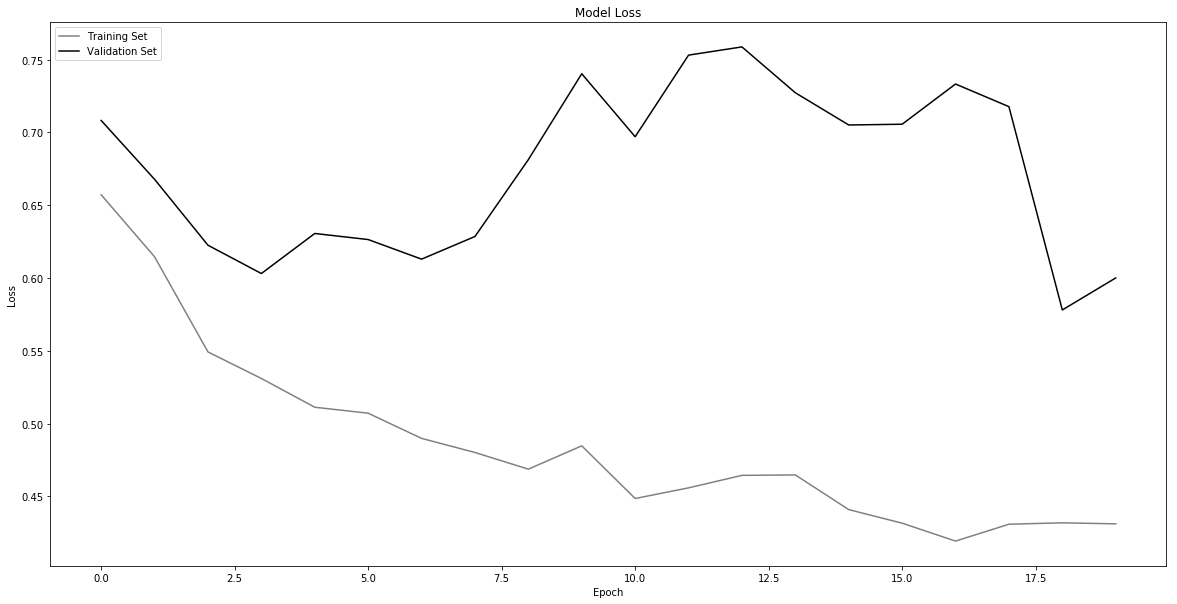

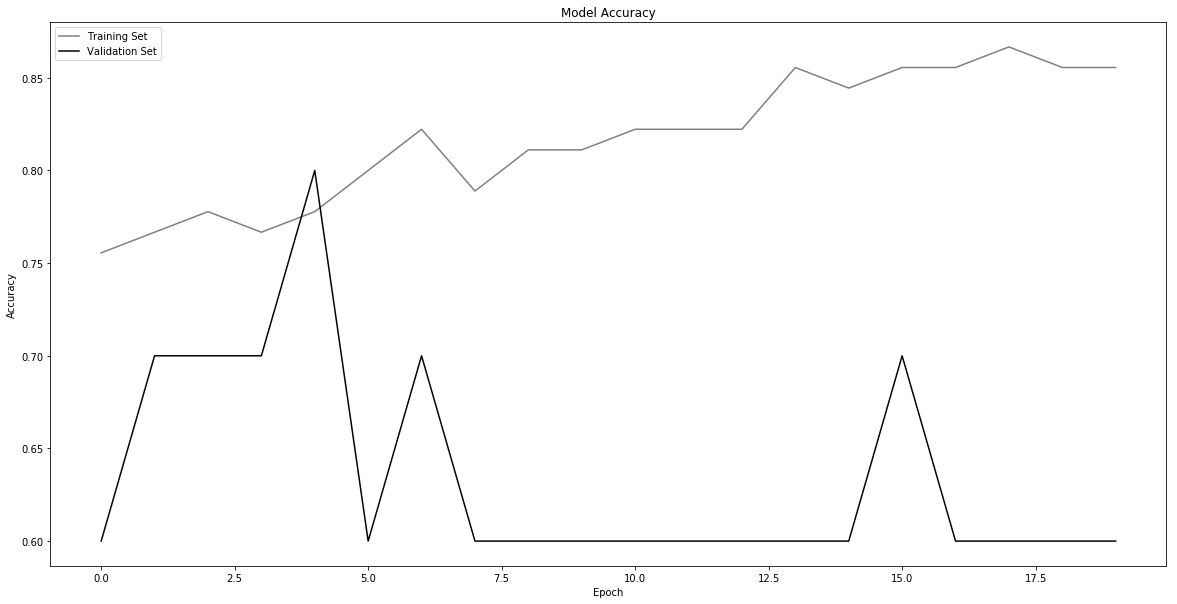

In [9]:
# Plotting cross-entropy loss
loss = [history_object.history["loss"] for history_object in history_objects]
val_loss = [history_object.history["val_loss"] for history_object in history_objects]

plt.figure(figsize=(20,10))
plt.plot(loss, color="grey")
plt.plot(val_loss, color="black")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper left')
plt.show()

# Plotting accuracy
acc = [history_object.history["acc"] for history_object in history_objects]
val_acc = [history_object.history["val_acc"] for history_object in history_objects]

plt.figure(figsize=(20,10))
plt.plot(acc, color="grey")
plt.plot(val_acc, color="black")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper left')
plt.show()

## Testing 

And of course the moment of truth is testing the models true performance on unseen data. Below we perform the same preprocessing/data transformation steps as for the training data, only this time predicting the results. We then round the predictions (thereby achieving actual 'classification') and then compute the accuracy which is shown below.

In [10]:
# Preprocessing and wrangling the test data.
t_preprocessed_reviews = np.array([preprocess_text(review) for review in test_df.data.values])
y_test = test_df.is_positive.values

t_tokenized_reviews = np.array([tokenize(review) for review in t_preprocessed_reviews])
del t_preprocessed_reviews 

t_embedded_inputs = [get_embedding(tokenized_review) for tokenized_review in t_tokenized_reviews]
del t_tokenized_reviews

In [11]:
# Batched testing as the padded sequences don't fit into RAM (Memory Errors)
predictions = []

for batch_idx in range(num_of_batches):
    start, end = (batch_idx*batch_size, (batch_idx+1)*batch_size)
    
    # This could break if a review in the test set was longer than the longest training set review.
    t_padded_inputs = pad_sequences(t_embedded_inputs[start:end], max_review_len*50,
                            padding="post").reshape(len(t_embedded_inputs[start:end]), -1, 50)
    
    predictions.extend(model.predict(t_padded_inputs))
    batch_iteration+=1

In [12]:
# Actually classifying the outputs (simple rounding). Cutoff is 0.5.
predictions_rounded = np.round(predictions).reshape(len(predictions),)

# Generating a boolean array of testing/prediction equalities and summing them up to get accuracy.
accuracy = (np.sum(y_test==predictions_rounded)/len(y_test))*100

print("Testing accuracy is: %.2f%%" % accuracy)

Testing accuracy is: 66.68%


In [13]:
print(predictions_rounded[15000:16000])

[1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.

## Conclusions
The results are far from ideal. Out of 3 seperate training runs, the model achieved 84.94%, 53.33% and now 66.68% testing accuracy. The model seems to be favoring positive sentiment predictions (as shown above for the 15,000-16,000 prediction range, where all of these sentiments should be 0). Most likely 20 epochs of training at batch size 100 is not long enough (juding from the fact that model seems like it's overfitting, but then validation loss drops significantly). We could also tinker with the output size of the GRU (currently set to 30). So next steps would be continued training and tuning of hyperparameters, or there's some bug that is causing horrific performance. The test set is not shuffled, however this should make absolutely no difference to the predictions.